# Inputs
There are 3 ways to input. 

First, you can save strategy returns in a direrctory names "projects", namely, the path is /content/drive/MyDrive/ahfs/project . The sma.ipynb atomatically saves to this folder.

Second, the codse below loads the FF five factors and it allows you to use them as a strategy. It is set up to just HML. It drops RF and the market factor due to the fact we don't want the market in our portfolio (you do remember we want low correlation with the market, right?) But if you want you can ad SMB HML or RMW  by changing the column drop below.

Third, and most flexible, you can use any ticker you can get from YAHOO finance. Do not use straight stocks, use ETF's and mutual funds. Be careful you don't use something with a life shorter than 2014 to now because the algo trunctaes to the smallest time servies in the bunch.

The code builds the returns and then does a maximized Sharpe Ratio portfolio. It allows shorting but does not allow leverage (sorry, needs a complex check for returns at end that is beyond me getting this done today).

At the bottom, it runs a Tear Sheet for your overall strategy and then one for each strategy. Use these results for you presentations.




# Mean-Variance Optimization

MPT solves for the optimal portfolio weights to minimize volatility for a given expected return, or maximize returns for a given level of volatility. The key requisite input are expected asset returns, standard deviations, and the covariance matrix. 

Diversification works because the variance of portfolio returns depends on the covariance of the assets and can be reduced below the weighted average of the asset variances by including assets with less than perfect correlation. In particular, given a vector, ω, of portfolio weights and the covariance matrix, $\Sigma$, the portfolio variance, $\sigma_{\text{PF}}$ is defined as:
$$\sigma_{\text{PF}}=\omega^T\Sigma\omega$$

Markowitz showed that the problem of maximizing the expected portfolio return subject to a target risk has an equivalent dual representation of minimizing portfolio risk subject to a target expected return level, $μ_{PF}$. Hence, the optimization problem becomes:
$$
\begin{align}
\min_\omega & \quad\quad\sigma^2_{\text{PF}}= \omega^T\Sigma\omega\\
\text{s.t.} &\quad\quad \mu_{\text{PF}}= \omega^T\mu\\ 
&\quad\quad \lVert\omega\rVert =1
\end{align}
$$

We can calculate an efficient frontier using `scipy.optimize.minimize` and the historical estimates for asset returns, standard deviations, and the covariance matrix. 

## Imports & Settings

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy.random import random, uniform, dirichlet, choice
from numpy.linalg import inv

from scipy.optimize import minimize

import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
!pip install backtrader
!pip install git+https://github.com/quantopian/pyfolio
!pip install yfinance
!pip install --upgrade tables
import backtrader as bt
from backtrader.feeds import PandasData
import pyfolio as pf
import yfinance as yf
from datetime import datetime
from datetime import date
from pathlib import Path

  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-nuqxigcq
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-nuqxigcq


In [ ]:
sns.set_style('whitegrid')
np.random.seed(42)

In [ ]:
cmap = sns.diverging_palette(10, 240, n=9, as_cmap=True)

## Prepare Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


We select historical data for tickers included in the S&P500 (according to Wikipedia) from 1998-2017.

## Compute Inputs

In [ ]:
startDt='2015-07-06'
endDt='2021-07-01'

In [ ]:
ff_factor = 'F-F_Research_Data_5_Factors_2x3_daily'
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start=startDt, end=endDt)[0]
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1487 entries, 2015-07-06 to 2021-05-28
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  1487 non-null   float64
 1   SMB     1487 non-null   float64
 2   HML     1487 non-null   float64
 3   RMW     1487 non-null   float64
 4   CMA     1487 non-null   float64
 5   RF      1487 non-null   float64
dtypes: float64(6)
memory usage: 81.3 KB


In [ ]:
proj_path = Path('/content/drive/MyDrive/ahfs/project') 
if proj_path.exists():
    import glob



    # get data file names

    local_path = r'/content/drive/MyDrive/ahfs/project'

    filenames = glob.glob(local_path + "/*.csv")

    dfs = []

    i=0
    for filename in filenames:
        if i==0:
          assetName=filename.rsplit( ".", 1 )[ 0 ]
          assetName=assetName.rsplit( "/", 1 )[ 1 ]
          dfs=pd.read_csv(filename)
          dfs.rename(columns={ dfs.columns[i+1]: assetName }, inplace = True)
        else:
          assetName=filename.rsplit( ".", 1 )[ 0 ]
          assetName=assetName.rsplit( "/", 1 )[ 1 ]
          ts=pd.read_csv(filename)
          ts.head()
          dfs=dfs.merge(ts,on="index")
          dfs.rename(columns={ dfs.columns[i+1]: assetName }, inplace = True)
        i=i+1
    dfs.head()
    dfs['Date']=dfs['index']
    dfs['Date'] = pd.to_datetime(dfs['Date'],utc=False)
    dfs.index=dfs['Date']

    dfs=dfs.drop("index",axis=1)
    dfs=dfs.drop("Date",axis=1)
    dfs=dfs.tz_convert(None)
    dfs=pd.merge(dfs, ff_factor_data/100, left_index=True, right_index=True)
else:
    dfs=ff_factor_data/100

In [ ]:
dfs.head()

,Macro,Momentum,FX,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,,,,
2015-07-06,0.0,0.0,0.0,-0.0037,0.0011,-0.0058,-0.0023,-0.0018,0.0
2015-07-07,0.0,0.0,0.0,0.0053,-0.0047,-0.0026,0.0041,-0.0001,0.0
2015-07-08,0.0,0.0,0.0,-0.0168,-0.0003,0.0008,0.0012,0.0013,0.0
2015-07-09,0.0,0.0,0.0,0.0029,0.0017,0.0000,-0.0028,-0.0026,0.0
2015-07-10,0.0,0.0,0.0,0.0124,0.0019,-0.0053,-0.0021,-0.0006,0.0


# Pick tickers here using mutual funds and ETF's for alternative benchmarks
Some ideas from here: https://money.usnews.com/funds/mutual-funds/alternative


In [ ]:
numCol=len(dfs.columns)
tickers = []
i=0
for ticker in tickers:
    data=yf.download(ticker,startDt, endDt)    
    rets=data['Adj Close'].pct_change()
    dfs=pd.merge(dfs, rets, left_index=True, right_index=True)
    dfs.rename(columns={ dfs.columns[numCol+i]: ticker }, inplace = True)
    i=i+1


In [ ]:
dfs.head()

,Macro,Momentum,FX,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,,,,
2015-07-06,0.0,0.0,0.0,-0.0037,0.0011,-0.0058,-0.0023,-0.0018,0.0
2015-07-07,0.0,0.0,0.0,0.0053,-0.0047,-0.0026,0.0041,-0.0001,0.0
2015-07-08,0.0,0.0,0.0,-0.0168,-0.0003,0.0008,0.0012,0.0013,0.0
2015-07-09,0.0,0.0,0.0,0.0029,0.0017,0.0000,-0.0028,-0.0026,0.0
2015-07-10,0.0,0.0,0.0,0.0124,0.0019,-0.0053,-0.0021,-0.0006,0.0


### Risk-Free Rate

Load historical 10-year Treasury rate:

In [ ]:
rf_rate = dfs['RF'].mean()
dfs2=dfs.drop(columns=["RF","Mkt-RF"]) # RF no longer needed and Mkt should not be part of your portfolio

In [ ]:
dfs2.head()

,Macro,Momentum,FX,SMB,HML,RMW,CMA
Date,,,,,,,
2015-07-06,0.0,0.0,0.0,0.0011,-0.0058,-0.0023,-0.0018
2015-07-07,0.0,0.0,0.0,-0.0047,-0.0026,0.0041,-0.0001
2015-07-08,0.0,0.0,0.0,-0.0003,0.0008,0.0012,0.0013
2015-07-09,0.0,0.0,0.0,0.0017,0.0000,-0.0028,-0.0026
2015-07-10,0.0,0.0,0.0,0.0019,-0.0053,-0.0021,-0.0006


# FF Factors removed here, HML left in by default for example

In [ ]:
dfs2=dfs2.drop(columns=["SMB","RMW","CMA"]) # Leave HML as an example so delete if not part of your strategy

### Compute Returns

Create month-end monthly returns and drop dates that have no observations:

In [ ]:
daily_returns= dfs2
daily_returns.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1487 entries, 2015-07-06 to 2021-05-28
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Macro     1487 non-null   float64
 1   Momentum  1487 non-null   float64
 2   FX        1487 non-null   float64
 3   HML       1487 non-null   float64
dtypes: float64(4)
memory usage: 58.1 KB


In [ ]:
daily_returns.head()

,Macro,Momentum,FX,HML
Date,,,,
2015-07-06,0.0,0.0,0.0,-0.0058
2015-07-07,0.0,0.0,0.0,-0.0026
2015-07-08,0.0,0.0,0.0,0.0008
2015-07-09,0.0,0.0,0.0,0.0000
2015-07-10,0.0,0.0,0.0,-0.0053


### Set  Parameters

In [ ]:
strategies = daily_returns.columns

In [ ]:
n_obs, n_assets = daily_returns.shape
n_assets, n_obs

(4, 1487)

In [ ]:
x0 = uniform(0, 1, n_assets)
x0 /= np.sum(np.abs(x0))

### Annualization Factor

In [ ]:
periods_per_year = round(daily_returns.resample('A').size().mean())
periods_per_year=252

### Compute Mean Returns, Covariance and Precision Matrix

In [ ]:
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

In [ ]:
mean_returns



Macro       0.000198
Momentum    0.000217
FX          0.000027
HML        -0.000173
dtype: float64

In [ ]:
cov_matrix

,Macro,Momentum,FX,HML
Macro,0.000016,4.519960e-06,-1.268666e-06,7.746282e-06
Momentum,0.000005,1.998760e-05,-3.790257e-08,-2.454111e-06
FX,-0.000001,-3.790257e-08,3.208964e-06,6.312856e-07
HML,0.000008,-2.454111e-06,6.312856e-07,8.045026e-05


The precision matrix is the inverse of the covariance matrix:

In [ ]:
precision_matrix = pd.DataFrame(inv(cov_matrix), index=strategies, columns=strategies)

## Compute Annualize PF Performance

Now we'll set up the quadratic optimization problem to solve for the minimum standard deviation for a given return or the maximum SR. 

To this end, define the functions that measure the key metrics:

In [ ]:
def portfolio_std(wt, rt=None, cov=None):
    """Annualized PF standard deviation"""
    return np.sqrt(wt @ cov @ wt * periods_per_year)

In [ ]:
def portfolio_returns(wt, rt=None, cov=None):
    """Annualized PF returns"""
    return (wt @ rt + 1) ** periods_per_year - 1

In [ ]:
def portfolio_performance(wt, rt, cov):
    """Annualized PF returns & standard deviation"""
    r = portfolio_returns(wt, rt=rt)
    sd = portfolio_std(wt, cov=cov)
    return r, sd

## Max Sharpe PF

Define a target function that represents the negative SR for scipy's minimize function to optimize, given the constraints that the weights are bounded by [-1, 1], if short trading is permitted, and [0, 1] otherwise, and sum to one in absolute terms.

In [ ]:
def neg_sharpe_ratio(weights, mean_ret, cov):
    r, sd = portfolio_performance(weights, mean_ret, cov)
    return -((r - rf_rate) / sd)

In [ ]:
weight_constraint = {'type': 'eq', 
                     'fun': lambda x: np.sum(np.abs(x))-1}

In [ ]:
def max_sharpe_ratio(mean_ret, cov, short=False):   # short-F because you can't short your own strategy
    return minimize(fun=neg_sharpe_ratio,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=((-1 if short else 0, 1),) * n_assets,
                    constraints=weight_constraint,
                    options={'tol':1e-10, 'maxiter':1e4})

## Run Calculations

### Get Max Sharpe PF

In [ ]:
max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix, short=False)
max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)

In [ ]:
print(max_sharpe_pf.x)

[0.35053307 0.26491376 0.38455317 0.        ]


In [ ]:
r, sd = max_sharpe_perf
pd.Series({'ret': r, 'sd': sd, 'sr': (r-rf_rate)/sd})

ret    0.035183
sd     0.032932
sr     1.067273
dtype: float64

From simulated pf data

In [ ]:
# Save weights
pWeights=max_sharpe_pf.x
pWeights

array([0.35053307, 0.26491376, 0.38455317, 0.        ])

# Now contsruct portfolios from weights

In [ ]:
myStrat=dfs2[strategies]
myStratRets=dfs2[strategies].mul(pWeights).sum(1)

In [ ]:
myStrat.head()

,Macro,Momentum,FX,HML
Date,,,,
2015-07-06,0.0,0.0,0.0,-0.0058
2015-07-07,0.0,0.0,0.0,-0.0026
2015-07-08,0.0,0.0,0.0,0.0008
2015-07-09,0.0,0.0,0.0,0.0000
2015-07-10,0.0,0.0,0.0,-0.0053


In [ ]:
myStratRets.head()

Date
2015-07-06    0.0
2015-07-07    0.0
2015-07-08    0.0
2015-07-09    0.0
2015-07-10    0.0
dtype: float64

## Run PyFolio Analysis

### Get Benchmark

In [ ]:
start = str(myStratRets.index.min())
end = str(myStratRets.index.max())

In [ ]:
myStratRets.head()

Date
2015-07-06    0.0
2015-07-07    0.0
2015-07-08    0.0
2015-07-09    0.0
2015-07-10    0.0
dtype: float64

In [ ]:
benchmark = web.DataReader('SP500', 'fred',
                           start=start,
                           end=end).squeeze()
benchmark = benchmark.pct_change().tz_localize(None)


### Create full tearsheet for overall and then for each

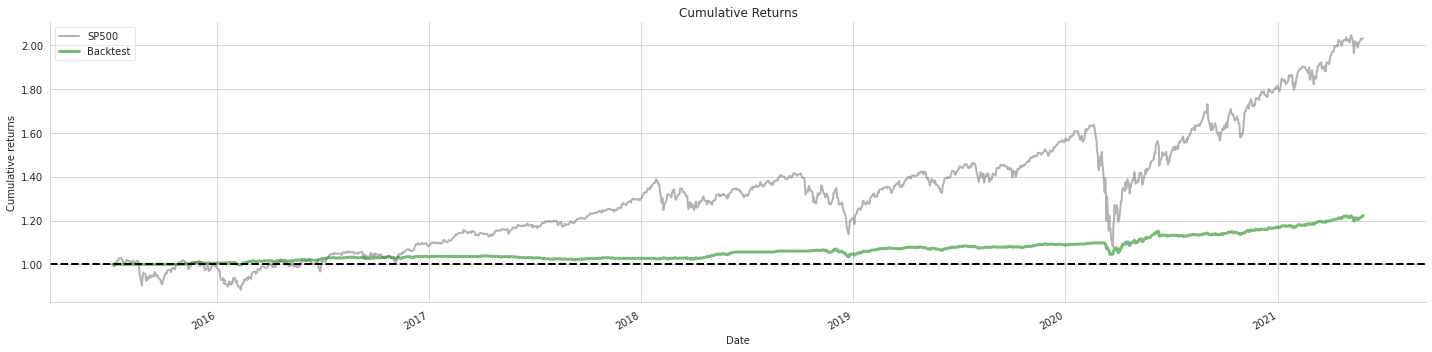

In [ ]:

fig, axes = plt.subplots(ncols=1, figsize=(20,5))
pf.plotting.plot_rolling_returns( myStratRets, factor_returns=benchmark)
axes.set_title('Cumulative Returns')
sns.despine()
fig.tight_layout();


Start date,2015-07-06
End date,2021-05-28
Total months,70
,Backtest
Annual return,3.462%
Cumulative returns,22.243%
Annual volatility,3.293%
Sharpe ratio,1.05
Calmar ratio,0.71
Stability,0.85
Max drawdown,-4.905%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.90,2020-02-20,2020-03-18,2020-04-14,39
1,3.40,2018-12-03,2018-12-24,2019-02-15,55
2,1.99,2020-06-08,2020-07-24,2020-11-09,111
3,1.92,2021-05-07,2021-05-12,2021-05-27,15
4,1.77,2017-04-07,2017-09-08,2018-05-02,279


Stress Events,mean,min,max
Fall2015,0.00%,0.00%,0.00%
New Normal,0.01%,-1.87%,1.92%


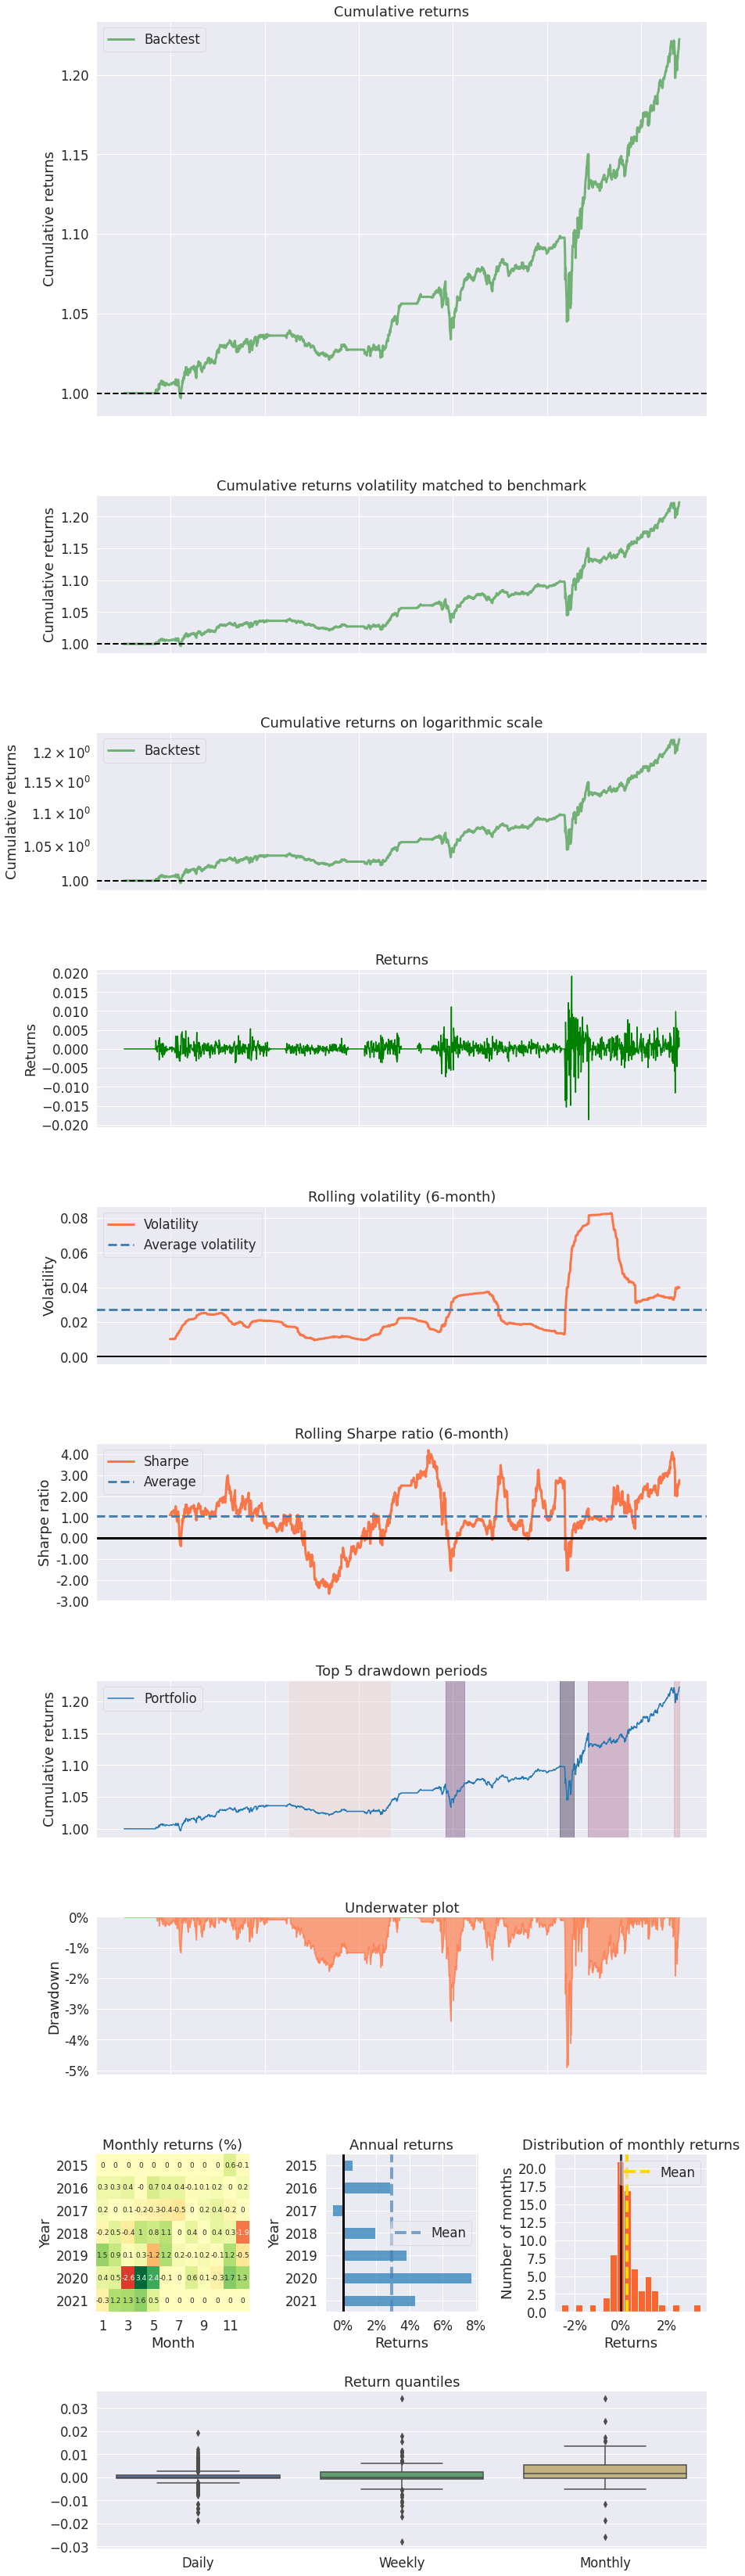

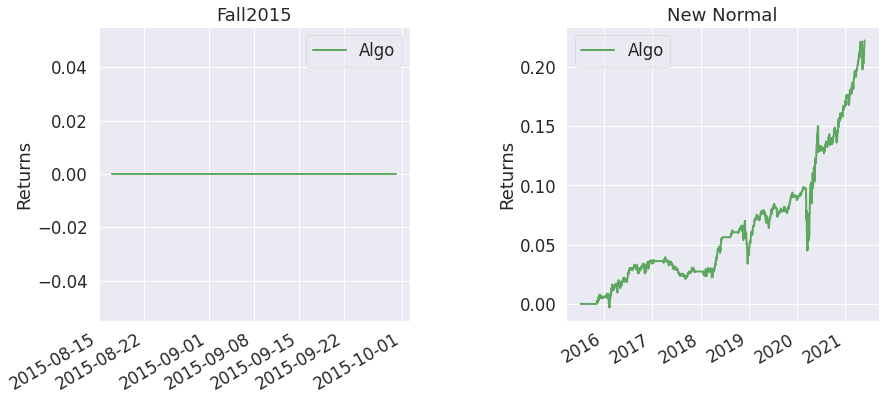

In [ ]:
pf.create_full_tear_sheet(myStratRets,
                          estimate_intraday=False)

Macro


Start date,2015-07-06
End date,2021-05-28
Total months,70
,Backtest
Annual return,4.901%
Cumulative returns,32.622%
Annual volatility,6.302%
Sharpe ratio,0.79
Calmar ratio,0.36
Stability,0.51
Max drawdown,-13.793%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,13.79,2019-07-12,2020-03-18,2020-08-03,277
1,4.67,2016-08-18,2018-04-02,2018-06-08,472
2,4.19,2019-04-08,2019-06-03,2019-06-20,54
3,3.52,2020-09-02,2020-09-23,2020-10-08,27
4,3.26,2020-10-12,2020-10-30,2020-11-05,19


Stress Events,mean,min,max
Fall2015,0.00%,0.00%,0.00%
New Normal,0.02%,-4.38%,3.48%


Momentum


Start date,2015-07-06
End date,2021-05-28
Total months,70
,Backtest
Annual return,5.364%
Cumulative returns,36.111%
Annual volatility,7.097%
Sharpe ratio,0.77
Calmar ratio,0.44
Stability,0.80
Max drawdown,-12.057%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.06,2018-12-03,2018-12-24,2019-02-15,55
1,7.11,2020-06-10,2021-05-12,NaT,NaN
2,5.53,2020-03-30,2020-04-01,2020-04-08,8
3,4.84,2018-11-07,2018-11-20,2018-12-03,19
4,3.62,2020-04-17,2020-04-21,2020-04-27,7


Stress Events,mean,min,max
Fall2015,0.00%,0.00%,0.00%
New Normal,0.02%,-3.93%,5.11%


FX


Start date,2015-07-06
End date,2021-05-28
Total months,70
,Backtest
Annual return,0.638%
Cumulative returns,3.824%
Annual volatility,2.844%
Sharpe ratio,0.24
Calmar ratio,0.13
Stability,0.59
Max drawdown,-4.984%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.98,2020-02-20,2021-01-06,NaT,NaN
1,4.03,2017-04-07,2017-09-08,2018-05-02,279
2,3.89,2016-01-22,2016-05-02,2016-10-12,189
3,1.77,2019-09-30,2019-12-31,2020-02-07,95
4,1.38,2019-03-07,2019-03-20,2019-04-18,31


Stress Events,mean,min,max
Fall2015,0.00%,0.00%,0.00%
New Normal,0.00%,-1.16%,1.71%


HML


Start date,2015-07-06
End date,2021-05-28
Total months,70
,Backtest
Annual return,-5.219%
Cumulative returns,-27.115%
Annual volatility,14.238%
Sharpe ratio,-0.31
Calmar ratio,-0.10
Stability,0.67
Max drawdown,-52.227%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,52.23,2016-12-22,2020-11-06,NaT,NaN
1,7.31,2015-10-08,2016-01-25,2016-04-28,146
2,5.19,2015-07-06,2015-09-18,2015-09-29,62
3,5.05,2016-05-18,2016-07-07,2016-10-17,109
4,1.97,2016-04-29,2016-05-09,2016-05-18,14


Stress Events,mean,min,max
Fall2015,0.04%,-1.51%,1.85%
New Normal,-0.02%,-4.89%,6.70%


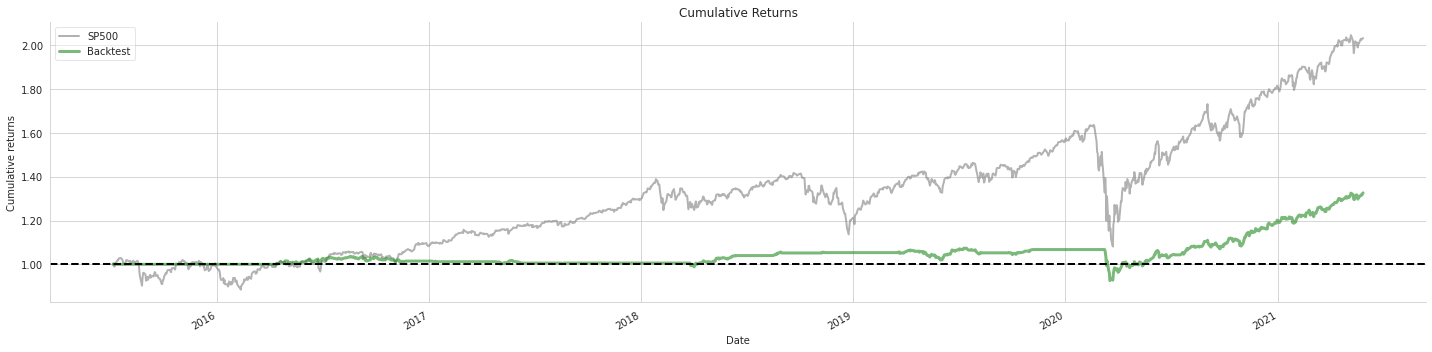

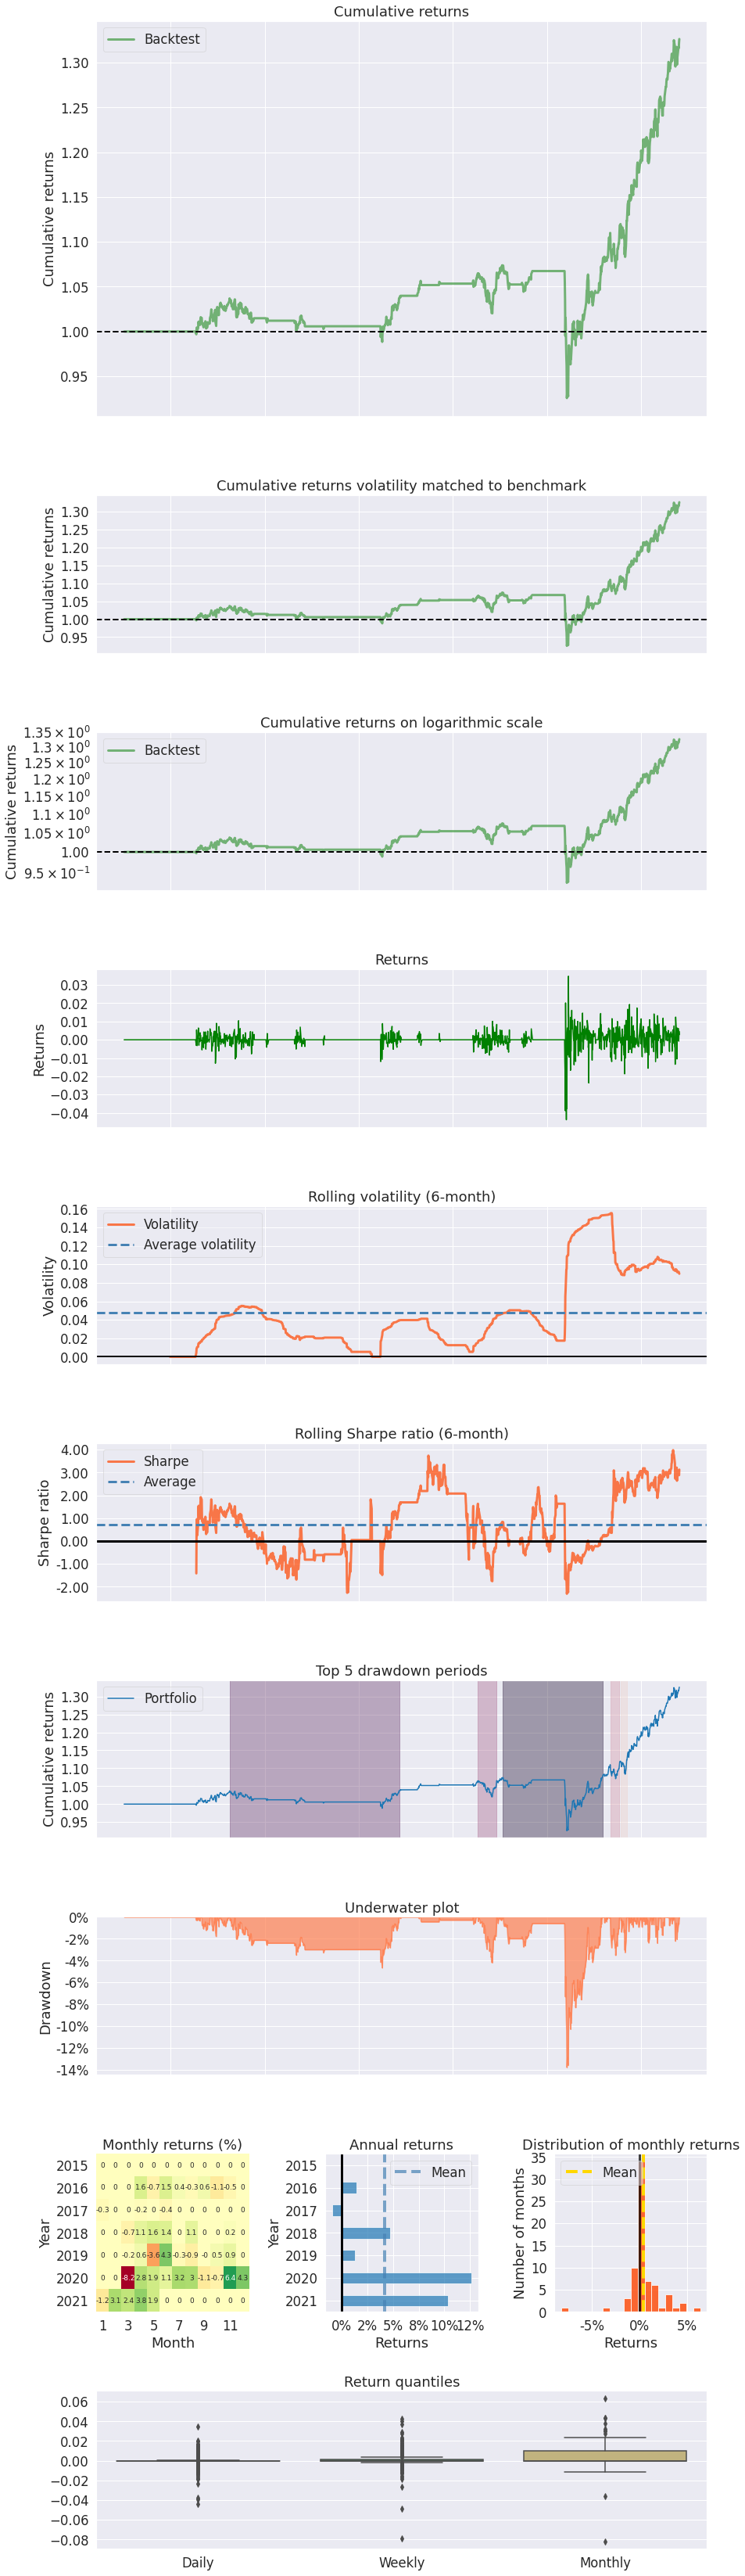

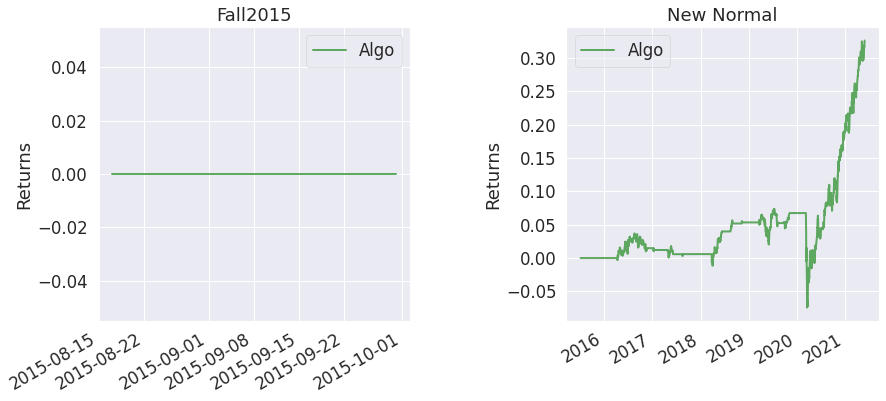

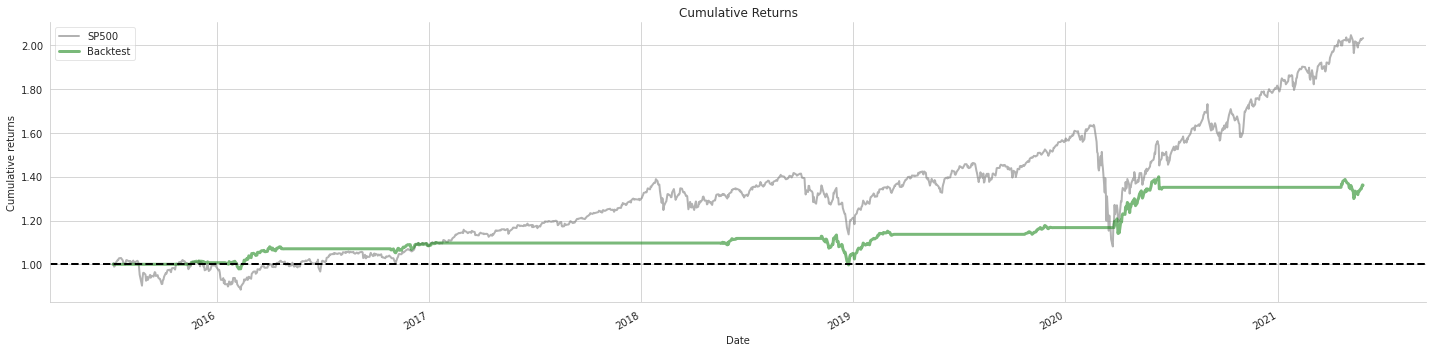

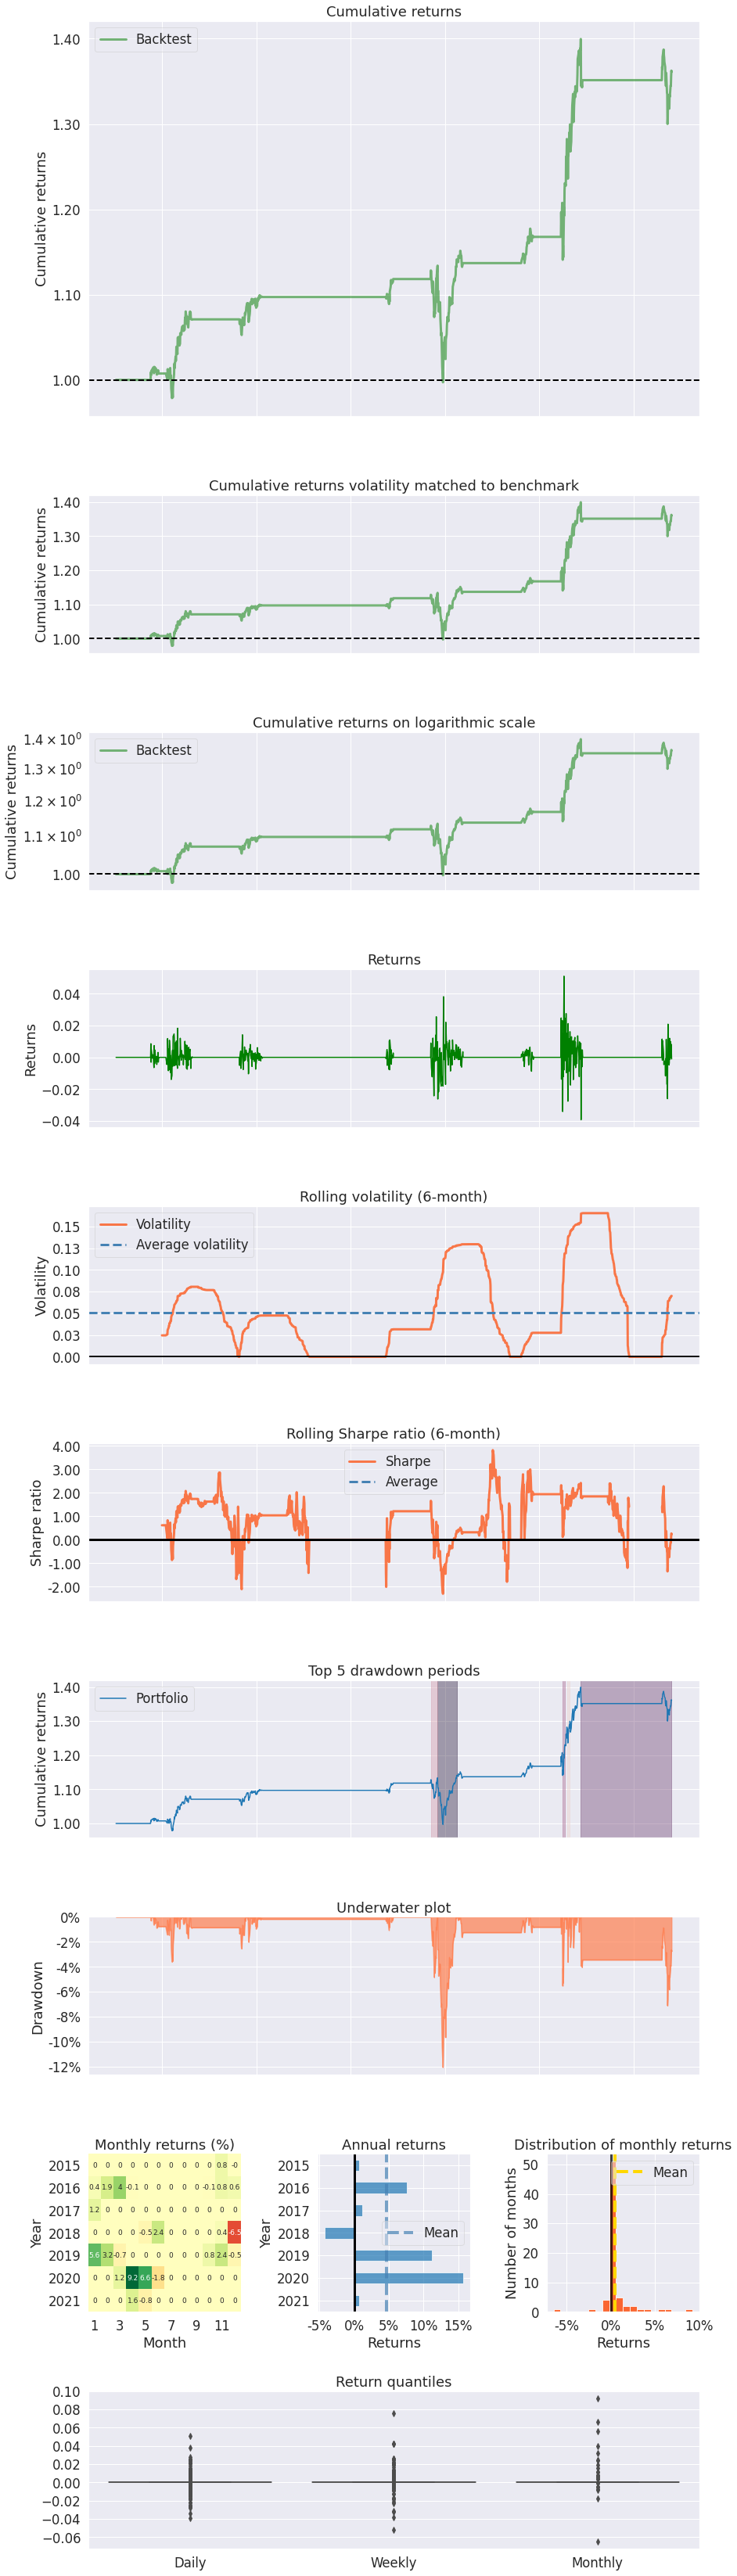

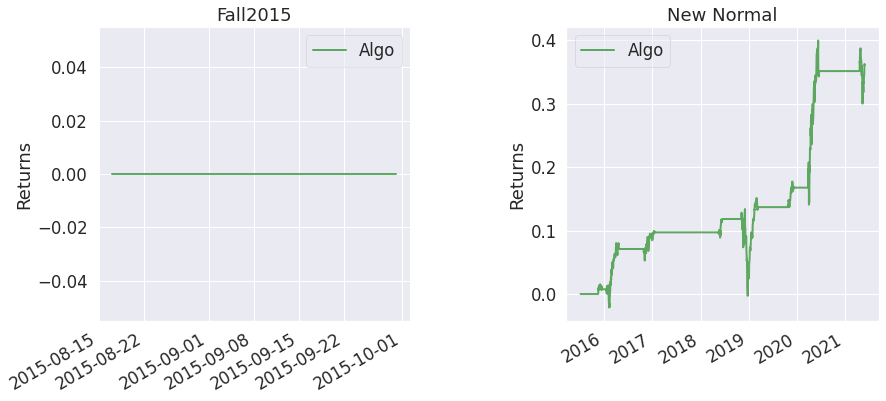

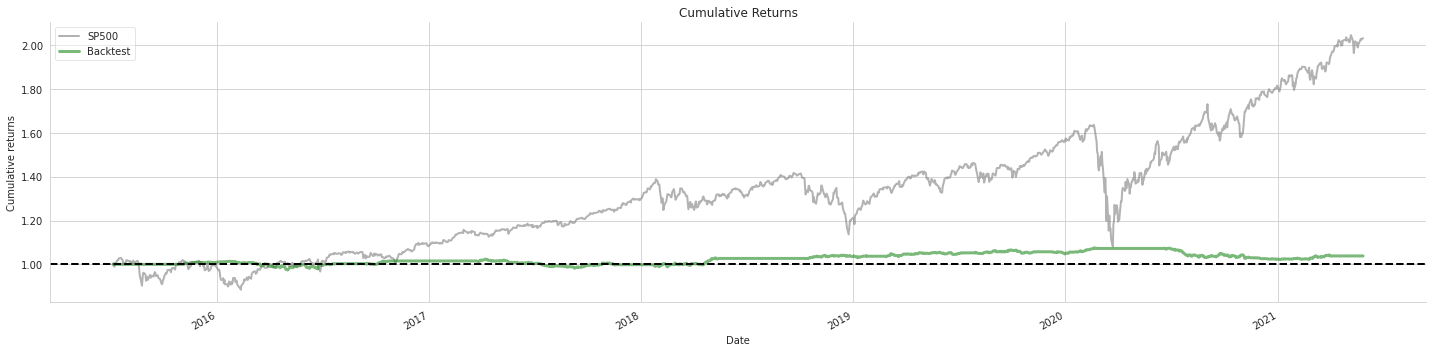

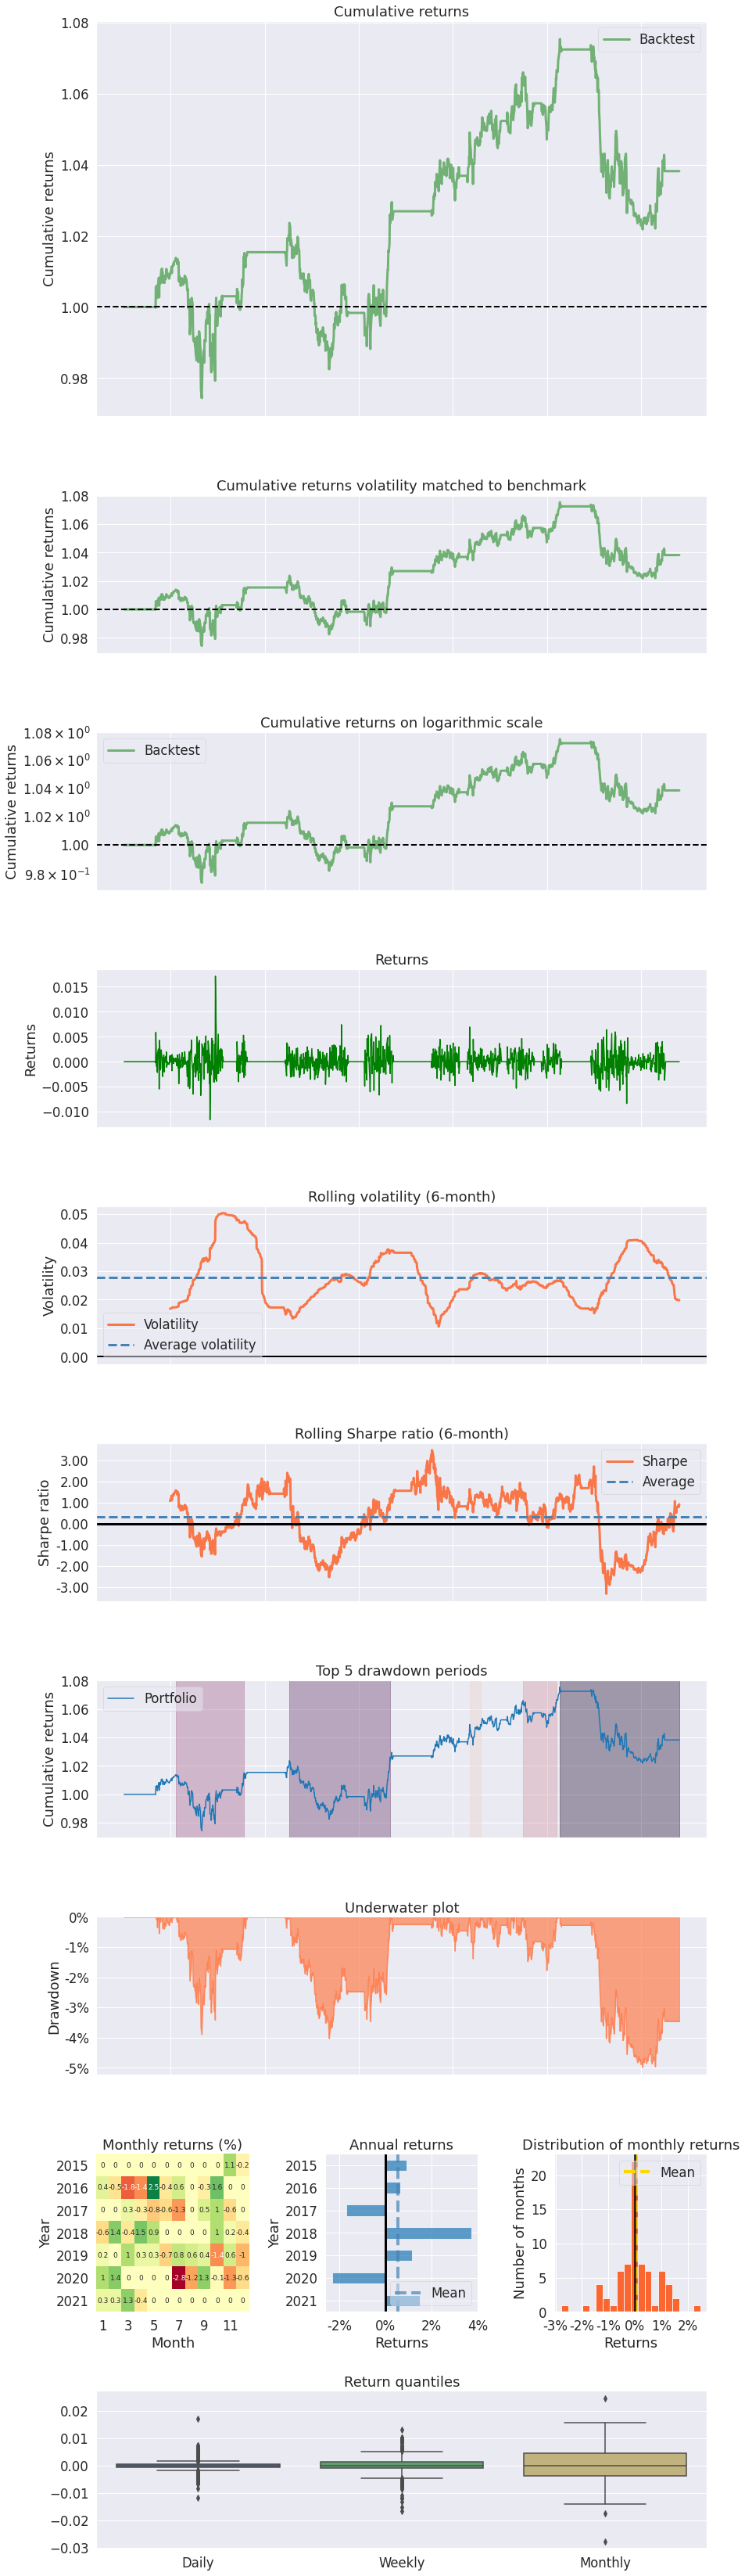

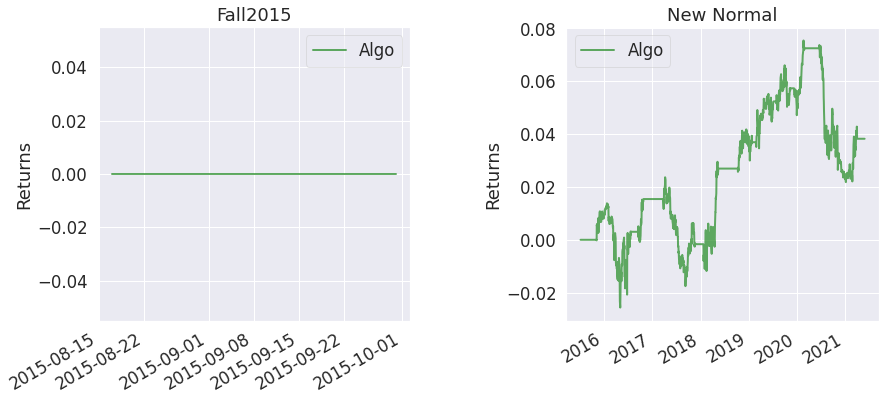

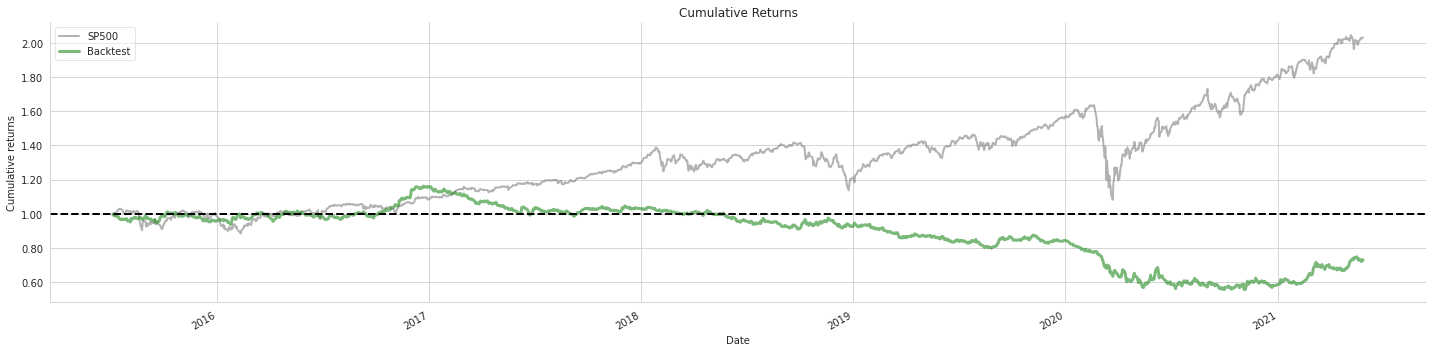

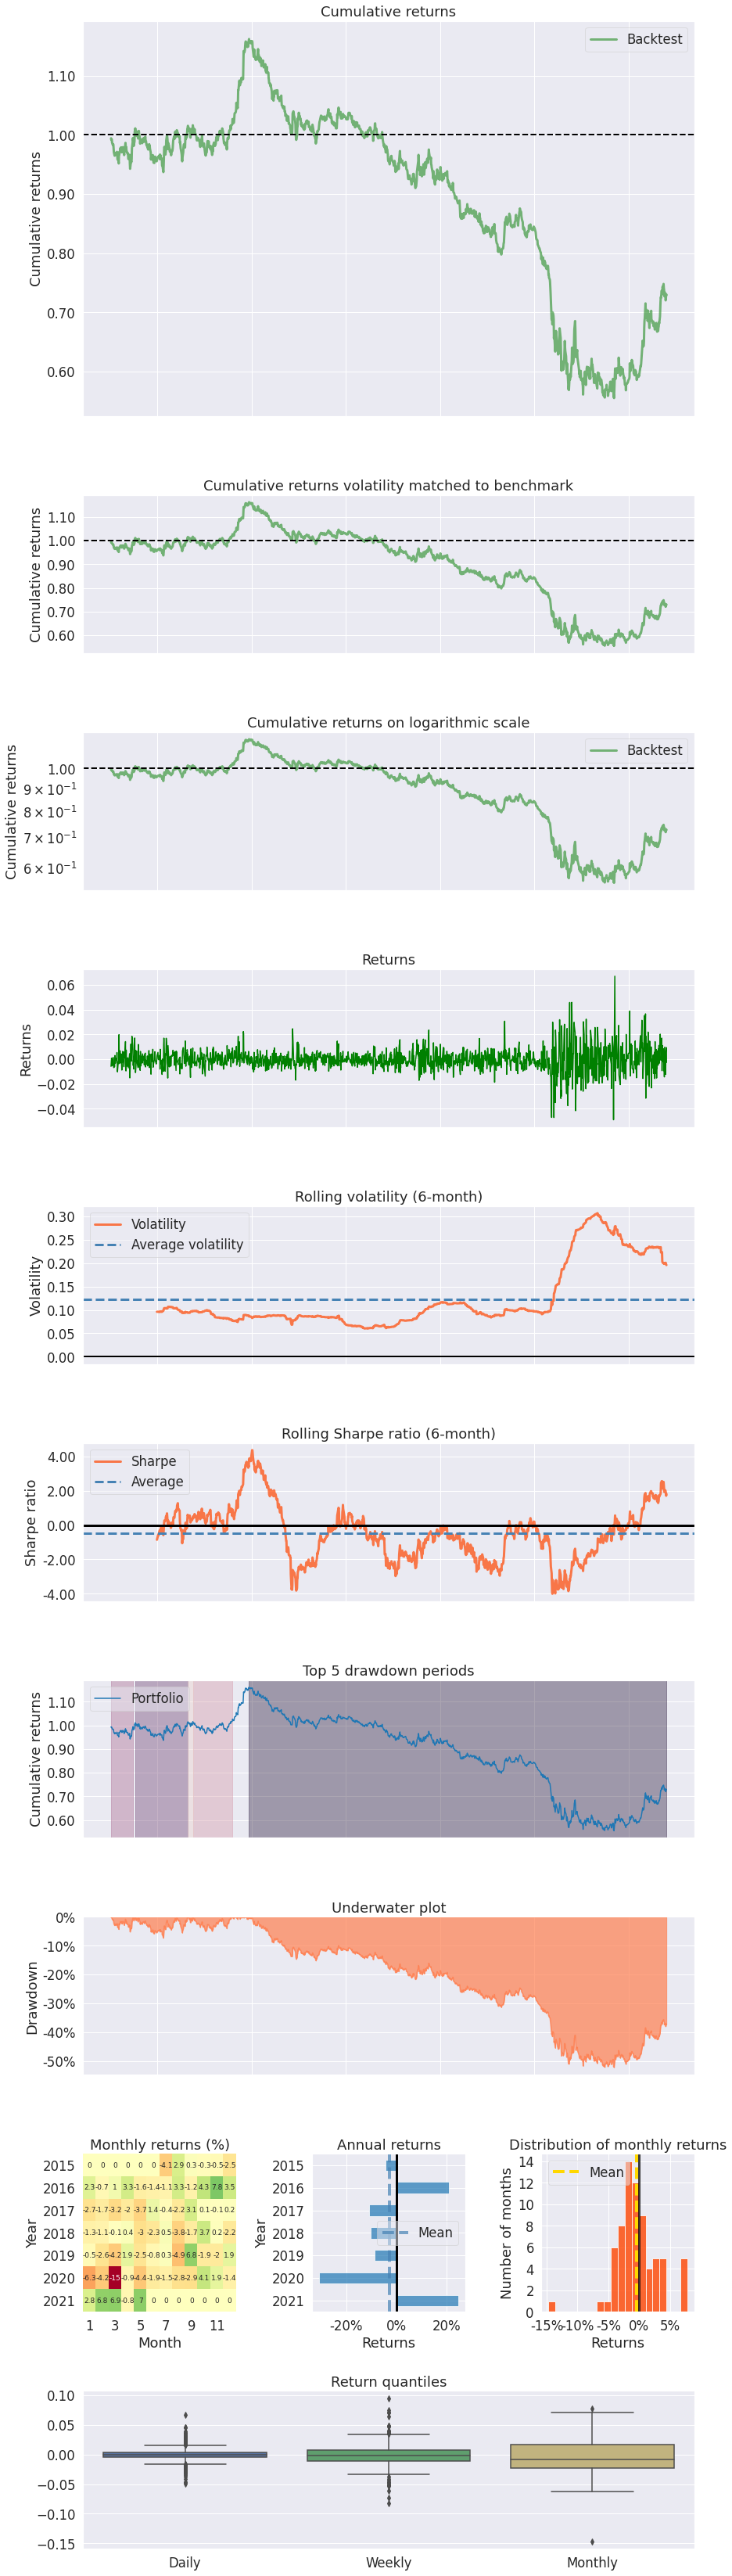

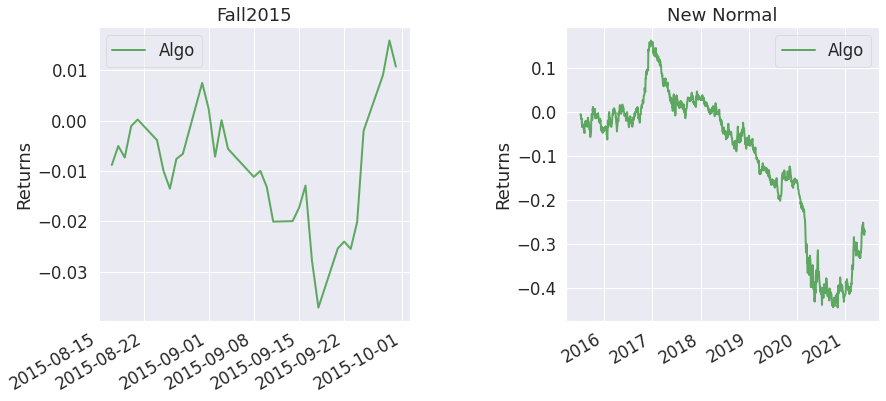

In [ ]:
for strat in strategies:
  print(strat)
  fig, axes = plt.subplots(ncols=1, figsize=(20,5))
  pf.plotting.plot_rolling_returns( myStrat[strat], factor_returns=benchmark)
  axes.set_title('Cumulative Returns')
  sns.despine()
  fig.tight_layout();
  pf.create_full_tear_sheet(myStrat[strat],
                          estimate_intraday=False)